c:\Users\gleilsonpedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Mnist accuracy: 0.9729985788725722


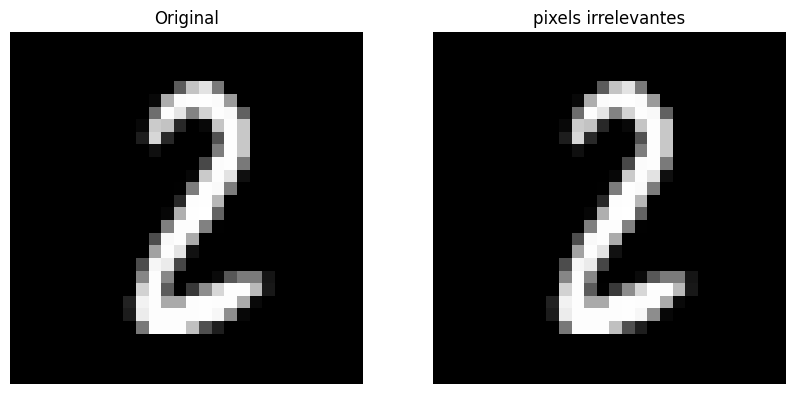

KeyboardInterrupt: 

In [39]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from z3 import *
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score 

# Carrega o dataset MNIST
mnist = fetch_openml('mnist_784', version=1, cache=True, parser='auto')
X, y = mnist.data, mnist.target
y = y.astype(np.uint8)

# Filtra as classes 2, 4 e 7
classes_to_keep = [2, 4, 7]
mask = np.isin(y, classes_to_keep)
X_filtered = X[mask]
y_filtered = y[mask]

# Divide os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.3, stratify=y_filtered)

# Pré-processamento dos dados (apenas para treino)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Treina o modelo de regressão logística
logistic_regression_classifier = LogisticRegression(multi_class='multinomial', max_iter=200)
logistic_regression_classifier.fit(X_train, y_train)

# Avalia a acurácia do modelo
predictions = logistic_regression_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions) 
print("Mnist accuracy:", accuracy)

# Função para plotar a imagem MNIST
def plot_mnist_image(image):
    plt.imshow(image.reshape(28, 28), cmap='binary')
    plt.axis('off')
    plt.show()

# Define as variáveis reais para o Z3
real_vars_mnist = [Real('x_' + str(i)) for i in range(X_filtered.shape[1])]

# Define as restrições de domínio
domain_constraints_mnist = [
    x <= u for (x, u) in zip(real_vars_mnist, X_filtered.max(axis=0))
] + [
    x >= l for (l, x) in zip(X_filtered.min(axis=0), real_vars_mnist)
]

# Define as equações da regressão logística para cada classe
logistic_reg_terms_mnist = [
    logistic_regression_classifier.coef_[i] @ real_vars_mnist + logistic_regression_classifier.intercept_[i]
    for i in range(3)
]

logistic_reg1_term = logistic_reg_terms_mnist[0] # Termo da regressão logística para a classe 0
logistic_reg2_term = logistic_reg_terms_mnist[1] # classe 1
logistic_reg3_term = logistic_reg_terms_mnist[2] # classe 2

# Função para calcular a explicação minimal
def minimalExplanation(I, D, P):
    """
    Calcula a explicação minimal para uma predição de classe específica.

    Args:
        I: Array de entrada com features.
        D: Restrições de domínio das features.
        P: Fórmula lógica representando a predição da classe.

    Returns:
        E: Lista de restrições de igualdade para a entrada.
        red_pixels: Lista de índices dos pixels irrelevantes.
    """
    E = [x == u for x, u in zip(real_vars_mnist, I)]  # Cria restrições de igualdade para a entrada original
    solver = Solver() # cria o solver
    red_pixels = [] # variável que irá receber os pixels irrelevantes
    for i in range(len(E) - 1, -1, -1):
        solver.reset()
        E_temp = E.copy()
        del E_temp[i]

        solver.add(E_temp)
        solver.add(D)
        solver.add(Not(P))
        if solver.check() != sat:
            E = E_temp.copy()
            red_pixels.append(i)

    return E, red_pixels

# Função para pintar os pixels modificados em vermelho
def pintar_pixels(imagem, deleted_pixels):
    """
    Pinta os pixels modificados em vermelho na imagem.

    Args:
        imagem: A imagem MNIST.
        deleted_pixels: Lista de índices dos pixels modificados.

    Returns:
        imagem: A imagem MNIST com os pixels modificados em vermelho.
    """

    imagem = imagem.reshape(28, 28).astype(np.uint8)
    imagem_rgb = Image.fromarray(imagem).convert("RGB")
    pixels = imagem_rgb.load()
    vermelho = (255, 0, 0)

    for index in deleted_pixels:
        x = index % 28
        y = index // 28
        pixels[x, y] = vermelho

    return imagem_rgb


# Calcula e plota as explicações minimais para o MNIST
for i in range(4):
    # Define a fórmula lógica para a predição da classe
    if predictions[i] == 1:
        formula = And(logistic_reg1_term > logistic_reg2_term, logistic_reg1_term > logistic_reg3_term)

    elif predictions[i] == 5:
        formula = And(logistic_reg2_term > logistic_reg1_term, logistic_reg2_term > logistic_reg3_term)

    else:
        formula = And(logistic_reg3_term > logistic_reg1_term, logistic_reg3_term > logistic_reg2_term)

    img, red_pixel = minimalExplanation(X_test.iloc[i].to_numpy(), domain_constraints_mnist, formula)

    img_rgb = pintar_pixels(X_test.iloc[i].to_numpy().reshape(28, 28), red_pixel)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(X_test.iloc[i].to_numpy().reshape(28, 28), cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    axs[1].imshow(img_rgb)
    axs[1].set_title('pixels irrelevantes')
    axs[1].axis('off')

    plt.show()